In [1]:
import json
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
sys.path.append("..")
from meta_model_training.utils import ndcg_sim, ndcg, custom_sim, f1_at_r, average_precision_at_r, load_meta_dataset, lower_bound
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

BENCHMARK_RESULTS_DIR = "../meta_dataset_creation/data/benchmark_results/"
META_FEATURES_DIR = "../meta_dataset_creation/data/meta_features/"

dataset_statistics = ["n_instances", "n_features",
                        "dim", "num_on_cat", "n_num_att", "n_cat_att"]

attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
    "lshkprototypes": "euclidean_dilca"
}

names = {
    "haverage": "H-AVG",
    "fasterpam": "K-MED",
    # "spectral": "Spectral",
    "kprototypes": "K-PROTO",
    "lshkprototypes": "LSH-KP",
}

In [2]:
from meta_model_training.utils import load_meta_dataset

meta_features_df, benchmark_results = load_meta_dataset(os.path.join(META_FEATURES_DIR, "meta_features.csv"), BENCHMARK_RESULTS_DIR)

Loading the meta-dataset
1. Loading the meta-features...DONE
2. Loading the clustering benchmark results...DONE
3. Filtering for external CVIs...DONE
# of datasets: 176
# of datasets for external CVIs: 95
# of meta-features: 61
# of pairs of similarity measures: 130


/homedir/adiop/workspace/simrec-for-mdc/paper/../meta_model_training/utils.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  benchmark_results[algorithm][cvi] = benchmark_results[algorithm][cvi][filtered]


In [3]:
train_res_dir = "../meta_model_training/data/training_results/"
train_res = {}
for name in os.listdir(train_res_dir):
    algorithm, cvi = name.split('.')[0].split('_')
    print(algorithm, cvi)
    if algorithm not in train_res:
        train_res[algorithm] = {}
    filename = os.path.join(train_res_dir, name)
    with open(filename, "rb") as f:
        train_res[algorithm][cvi] = pickle.load(f)
        # train_res[algorithm][cvi]["selected_features2"] = np.array([col for col in mixed_meta_df.columns if col in dataset_statistics+attributes_statistics])[selected_feats2]

kprototypes acc
kprototypes sil
kprototypes ari
fasterpam acc
fasterpam sil
fasterpam ari
haverage acc
haverage sil
haverage ari
lshkprototypes acc
lshkprototypes sil
lshkprototypes ari


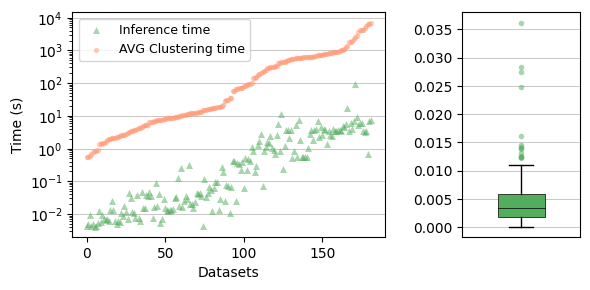

In [4]:
with open(os.path.join(META_FEATURES_DIR, "meta_features_times.json"), "r") as f:
    mf_durations = json.load(f)
    mf_durations = {int(k): v for k, v in mf_durations.items()}

benchmark_durations = {}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    with open(os.path.join(BENCHMARK_RESULTS_DIR, f"{algorithm}/times.json"), "r") as f:
        times = json.load(f)
        benchmark_durations[algorithm] = {int(k): v for k, v in times.items()}

x = []
# size = []
y1 = []
y2 = []
y3 = []
for k, v in benchmark_durations["kprototypes"].items():
    # if str(k) in meta_features_df.index:
    if k in mf_durations:
        # size.append(meta_features_df.at[str(k), "n_instances"]*meta_features_df.at[str(k), "n_features"])
        x.append(mf_durations[k])
        y1.append(benchmark_durations["kprototypes"][k])
        y2.append(benchmark_durations["fasterpam"][k])
        y3.append(benchmark_durations["haverage"][k])
indices = np.argsort(y1)
x = np.array(x)[indices]
y1 = np.array(y1)[indices]
y2 = np.array(y2)[indices]
y3 = np.array(y3)[indices]
plt.figure(figsize=(6, 3))
plt.subplot(1, 3, (1, 2))
plt.scatter(np.arange(len(x)), x, marker="^", s=25, label="Inference time", c="#52AD5D", linewidths=0, alpha=0.5, zorder=2)
plt.scatter(np.arange(len(y1)), y1/120, s=15, label="AVG Clustering time", c="#FF9671", linewidths=0, alpha=0.5, zorder=2)
plt.yscale("log")
# plt.axhline(y=np.quantile(x/y*120, 0.25), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.5), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.75), color="gray", linewidth=0.5)
plt.grid(axis="y", linewidth=0.5)
plt.ylabel("Time (s)")
plt.xlabel("Datasets")
plt.legend(fontsize=9)
plt.subplot(1, 3, 3)
boxprops = dict(linewidth=0.5, facecolor="#52AD5D", alpha=1) # "#52AD5D", "#FF9671"
flierprops = dict(marker='o', markerfacecolor="#52AD5D", markeredgecolor='none', markersize=4, alpha=0.5,
                linewidth=0)
medianprops = dict(color='black', linewidth=0.5)
meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
b = plt.boxplot([x/y1*120], widths=0.4, patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
plt.xticks([])
# plt.ylabel("$\\frac{\\text{Inference Time}}{\\text{AVG Clustering Time}}$", fontsize=12)
# plt.yscale("log")
plt.grid(axis="y", linewidth=0.5)
plt.tight_layout(w_pad=2)
# plt.savefig(f"imgs/inference_time_kprototypes.pdf")
plt.show()

In [5]:
import openml

openml_df = openml.datasets.list_datasets(output_format="dataframe")
df = openml_df[openml_df.NumberOfNumericFeatures >= 1]
df = df[df.NumberOfSymbolicFeatures >= 2]
df = df[df.NumberOfInstances >= 30]
df = df[df.NumberOfMissingValues <= 0.1 *
        df.NumberOfFeatures*df.NumberOfInstances]
df = df[df.NumberOfClasses >= 2]
df = df[df.version == 1]
dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
df= df.rename(columns=dict_)

df[df.did.isin(meta_features_df.index.astype(int))][dict_.values()].describe().astype(int)

,Features,Instances,Num. Features,Cat. Features,Classes
count,100,100,100,100,100
mean,34,160806,20,14,4
std,48,730118,41,19,6
min,3,36,1,2,2
25%,10,225,5,3,2
50%,18,977,8,7,2
75%,33,7043,20,17,4
max,300,5100000,294,137,48


/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


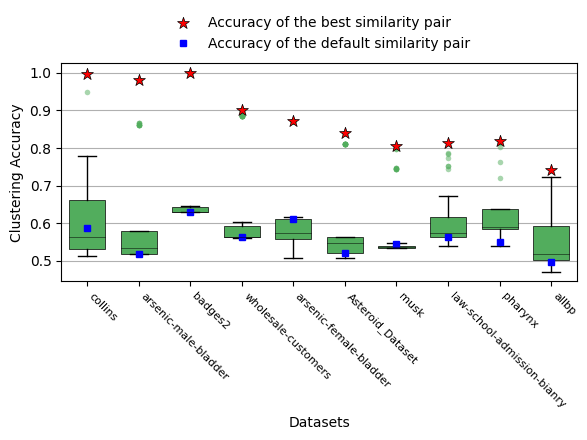

In [4]:
algorithm = "kprototypes"
cvi = "acc"
lb_index = benchmark_results[algorithm][cvi].columns.to_list().index(baseline_pairs[algorithm])
# names = []
# for did in benchmark_result.index:
#     filename = f"{algorithm}/scores/"
Y = benchmark_results[algorithm][cvi].to_numpy()
l = np.array([np.mean(max(y) - y[y>-1]) for y in Y])
l = np.argsort(-l)[:10]

plt.figure(figsize=(6, 4.5))
boxprops = dict(linewidth=0.5, facecolor="#52AD5D", alpha=1) # "#52AD5D", "#FF9671"
flierprops = dict(marker='o', markerfacecolor="#52AD5D", markeredgecolor='none', markersize=4, alpha=0.5,
                linewidth=0)
medianprops = dict(color='black', linewidth=0.5, alpha=0.7)
meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
x = np.arange(len(l))
b = plt.boxplot([y[y>-1] for y in Y[l]], positions=x, widths=0.7, patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)

plt.scatter(x, [max(y[y>-1]) for y in Y[l]], marker="*", c="r", s=80, label="Accuracy of the best similarity pair", linewidths=0.5, edgecolor="black", zorder=2)
plt.plot(x, [y[lb_index] for y in Y[l]], "s", color="b", markersize=5, label="Accuracy of the default similarity pair")
plt.xticks(x, [openml.datasets.get_dataset(benchmark_results[algorithm][cvi].index[did]).name for did in l], rotation=-45, horizontalalignment="left", fontsize=8)
# plt.plot(x, [np.median(y[y>-1]) for y in Y[l]], "s", color="r")
plt.xlabel("Datasets")
plt.ylabel("Clustering Accuracy")
plt.grid(axis="y")
plt.legend(fontsize=10, frameon=False, loc= "lower center", bbox_to_anchor= (0.5, 1), ncol=1)
plt.tight_layout()
# plt.savefig("imgs/acc_variation_on_some_datasets.pdf", bbox_inches='tight')
plt.show()

In [4]:
results = {}
for algorithm in train_res:
    results[algorithm] = {}
    for cvi in train_res[algorithm]:
        print(algorithm, cvi)
        results[algorithm][cvi] = {}
        Y = train_res[algorithm][cvi]["Y"]
        lower_bound_cvi = lower_bound(cvi)
        Yn =  np.array([(y-lower_bound_cvi)/max(y-lower_bound_cvi) for y in Y])
        Yn[Yn <= 0] = -1
        Yn4 = np.array(Yn)
        Yn4[Yn4 > 0] **= 4
        # print((Yn>=0.95).sum(axis=1))

        ndcg_ranks = [1, 3, 5, 10, 15, 20]
        n_bests = [1, 3, 5, 10, 15, 20]
        ndcg_scores = {
            model_name: {p: np.zeros(Y.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][cvi]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}
        f1_scores = {
            model_name: {p: np.zeros(Y.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][cvi]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}
        ap_scores = {
            model_name: {p: np.zeros(Y.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][cvi]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}
        mrr_scores = {
            model_name: np.zeros(Y.shape[0])
            for model_name in train_res[algorithm][cvi]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

        lb_scores = np.zeros(Y.shape[0])
        rb_scores = {k: np.zeros(Y.shape[0]) for k in n_bests}
        mb_scores = np.zeros(Y.shape[0])
        model_scores = {
            model_name: {k: np.zeros(Y.shape[0]) for k in n_bests}
            for model_name in train_res[algorithm][cvi]["train_results"]
        } #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}
   

        similarity_pairs = train_res[algorithm][cvi]["similarity_pairs"]
        sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))
        lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
        if algorithm == "lshkprototypes":
            lb_scores[lb_scores==-1] = Y[:, sim_pairs_index["euclidean_hamming"]][lb_scores==-1]
        mb_scores = np.max(Y, axis=1)[lb_scores>-1]


        for name, obj in train_res[algorithm][cvi]["train_results"].items():
            Y_pred = obj["pred"]
            for r in ndcg_ranks:
                ndcg_scores[name][r] = ndcg(Yn4, Y_pred, p=r)[lb_scores>-1]
                f1_scores[name][r] = np.nan_to_num(f1_at_r((Yn>=0.95)*1, Y_pred, r=r))[lb_scores>-1]
                ap_scores[name][r] = average_precision_at_r((Yn>=0.95)*1, Y_pred, r=r)[lb_scores>-1]
            for k in n_bests:
                model_scores[name][k] = np.array(
                    [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y)])[lb_scores>-1]
            mrr_scores[name] = np.array([
                1/(1+list(y[y > -1][np.argsort(-Y_pred[i][y > -1])]).index(max(y))) for i, y in enumerate(Y)
            ])[lb_scores>-1]
        for k in n_bests:
            rb_scores[k] = np.array(
                [max(np.random.choice(y[y > -1], k)) for y in Y])[lb_scores>-1]

        lb_scores = lb_scores[lb_scores>-1]
        results[algorithm][cvi]["scores"] = model_scores
        results[algorithm][cvi]["scores"]["LB"] = {1: lb_scores}
        results[algorithm][cvi]["scores"]["RB"] = rb_scores
        results[algorithm][cvi]["scores"]["Oracle"] = {1: mb_scores}
        results[algorithm][cvi]["ndcg"] = ndcg_scores
        results[algorithm][cvi]["f1"] = f1_scores
        results[algorithm][cvi]["ap"] = ap_scores
        results[algorithm][cvi]["mrr"] = mrr_scores

kprototypes acc


/homedir/adiop/workspace/simrec-for-mdc/paper/../meta_model_training/utils.py:163: RuntimeWarning: invalid value encountered in divide
  return 2*precision*recall/(precision + recall)


kprototypes sil
kprototypes ari
fasterpam acc
fasterpam sil
fasterpam ari
haverage acc
haverage sil
haverage ari
lshkprototypes acc
lshkprototypes sil
lshkprototypes ari


In [13]:
sota_results = {
    "786": {
        "name": "cleveland", #heart-desease
        "acc": {
            # "CB-DCGANs": 0.885,  # Clustering of mixed datasets using deep learning algorithm
            # "DP-MD-FN": 0.8148,  # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.7411, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.7525,  # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8218, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0.8313, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0,
        }
    },
    "29": {
        "name": "credit-aproval",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0.8668, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.6634, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.7525, # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8407, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0.7563, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    "40981": {
        "name": "australian-credit-aproval",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0.8551, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.6668, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.6000, # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8652, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.7942, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    # "10": {
    #     "name": "lymphography",
    #     "acc": {
    #         # "CB-DCGANs": 0,
    #         "DP-MD-FN": 0,
    #         "OCIL": 0,
    #         "SBAC": 0.5676, # A novel density peaks clustering algorithm for mixed data
    #         "DPC-MD": 0.8218, # A novel density peaks clustering algorithm for mixed data
    #         "OCIL2": 0.6154, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #         "ADC": 0.6928, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #     }
    # },
    # "31": {
    #     "name": "german credit",
    #     "acc": {
    #         "CB-DCGANs": 0,
    #         "DP-MD-FN": 0,
    #         "OCIL": 0,
    #         "SBAC": 0,
    #         "DPC-MD": 0,
    #         "OCIL2": 0.6943, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
    #         "ADC": 0.6134, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #     }
    # },
    "35": {
        "name": "dermatology",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0,
            "OCIL": 0,
            "SBAC": 0,
            # "DPC-MD": 0,
            "OCIL2": 0.6974, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.834, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    "45557": {
        "name": "mammographic",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0,
            "OCIL": 0,
            "SBAC": 0,
            # "DPC-MD": 0,
            "OCIL2": 0, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.8313, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    }
}

In [14]:
algorithm, cvi = "fasterpam", "acc"
benchmark_results = train_res[algorithm][cvi]["meta_dataset"][1]
dataId2idx = dict(zip(benchmark_results.index.values, np.arange(benchmark_results.shape[0])))
obj = {}
for data_id, res in sota_results.items():
    name = res["name"]
    obj[name] = {}
    for method, score in res["acc"].items():
        if score > 0:
            obj[name][method] = score
    obj[name]["SimRec"] = results[algorithm][cvi]["scores"]["AMF-FS-KNN"][1][dataId2idx[data_id]]
    obj[name]["Best"] = max(benchmark_results.loc[data_id])
pd.DataFrame.from_dict(obj, orient="index")

,OCIL,SBAC,OCIL2,SimRec,Best,ADC
cleveland,0.7411,0.7525,0.8313,0.818182,0.858586,NaN
credit-aproval,0.6634,0.7525,0.7563,0.800919,0.840735,NaN
australian-credit-aproval,0.6668,0.6000,NaN,0.849275,0.853623,0.7942
dermatology,NaN,NaN,0.6974,0.946927,0.946927,0.8340
mammographic,NaN,NaN,NaN,0.789410,0.797834,0.8313


In [89]:
model_names = ["LB", "RB", "AR", "AMF-FS-KNN", "Oracle"]
obj = {name: {} for name in model_names}
for algorithm in ["kprototypes", "fasterpam", "haverage", "lshkprototypes"]:
    for cvi in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][cvi]["Y"]
        lb_scores = results[algorithm][cvi]["scores"]["LB"][1]
        for name in model_names:
            l = results[algorithm][cvi]["scores"][name][1]
            # if cvi in ["sil"]:
            #     l = (l+1)/(best_scores+1)
            # elif cvi in ["acc"]:
            #     l = (l)/(best_scores)
            # elif cvi in ["ari"]:
            #     l = (l+0.5)/(best_scores+0.5)
            obj[name][f"{algorithm[0]}-{cvi}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{int((np.mean(l)/np.mean(lb_scores)-1)*100)}%" if name=="AMF-FS-KNN" else "")
        
        # obj["Oracle"][f"{algorithm[0]}-{cvi}"] = \
        #         f"{np.format_float_positional(np.mean(best_scores), 3)}±{np.format_float_positional(np.std(best_scores), 2)}"

print(pd.DataFrame.from_dict(obj, orient="columns"))
print()

               LB          RB          AR       AMF-FS-KNN      Oracle
k-sil  0.473±0.23  0.463±0.20   0.570±0.2  0.610±0.21 ↑28%   0.692±0.2
k-ari  0.232±0.23  0.218±0.22  0.234±0.24  0.291±0.25 ↑25%  0.371±0.26
k-acc  0.705±0.12  0.707±0.11   0.74±0.11   0.753±0.12 ↑6%   0.807±0.1
f-sil  0.477±0.27  0.499±0.25  0.613±0.23  0.657±0.22 ↑37%  0.733±0.20
f-ari  0.222±0.23  0.201±0.22  0.223±0.24  0.268±0.26 ↑20%  0.343±0.27
f-acc  0.724±0.12  0.723±0.11  0.725±0.12   0.754±0.12 ↑4%  0.797±0.10
h-sil    0.52±0.2  0.569±0.20  0.644±0.19  0.721±0.18 ↑38%  0.781±0.18
h-ari  0.213±0.24  0.176±0.22  0.239±0.26  0.269±0.26 ↑26%  0.329±0.26
h-acc  0.785±0.11  0.775±0.12  0.793±0.11   0.800±0.10 ↑1%  0.829±0.09
l-sil  0.517±0.21  0.483±0.23  0.567±0.23  0.643±0.21 ↑24%    0.72±0.2
l-ari  0.250±0.24  0.217±0.23  0.218±0.21  0.284±0.24 ↑13%  0.401±0.25
l-acc  0.749±0.12  0.733±0.12  0.760±0.11   0.785±0.11 ↑4%  0.833±0.08



In [61]:
model_names = ["LB", "RB", "AR", "AMF-FS-KNN"]
obj = {name: {} for name in model_names}
for algorithm in ["kprototypes", "fasterpam", "haverage", "lshkprototypes"]:
    for cvi in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][cvi]["Y"]
        # lb_scores = results[algorithm][cvi]["scores"]["LB"][1]
        best_scores = results[algorithm][cvi]["scores"]["Oracle"][1]
        for name in model_names:
            l = results[algorithm][cvi]["scores"][name][1]
            l = (l-lower_bound(cvi))/(best_scores - lower_bound(cvi))
            if name == "LB":
                lb_scores = l
            obj[name][f"{algorithm[0]}-{cvi}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{int((np.mean(l)/np.mean(lb_scores)-1)*100)}%" if name=="AMF-FS-KNN" else "")
        
        # obj["Oracle"][f"{algorithm[0]}-{cvi}"] = \
        #         f"{np.format_float_positional(np.mean(best_scores), 3)}±{np.format_float_positional(np.std(best_scores), 2)}"

print(pd.DataFrame.from_dict(obj, orient="columns"))
print()

               LB          RB          AR       AMF-FS-KNN
k-sil   0.872±0.1  0.849±0.10  0.930±0.07   0.953±0.06 ↑9%
k-ari  0.853±0.14  0.839±0.15  0.855±0.14   0.915±0.11 ↑7%
k-acc  0.873±0.12  0.873±0.11  0.916±0.09   0.932±0.09 ↑6%
f-sil  0.852±0.10   0.851±0.1  0.932±0.08  0.956±0.06 ↑12%
f-ari  0.869±0.12  0.876±0.13  0.871±0.13    0.916±0.1 ↑5%
f-acc  0.908±0.09  0.904±0.09   0.91±0.09   0.945±0.06 ↑4%
h-sil  0.854±0.08  0.864±0.08  0.924±0.07  0.967±0.05 ↑13%
h-ari  0.873±0.14  0.843±0.15  0.895±0.12   0.928±0.09 ↑6%
h-acc  0.948±0.08  0.927±0.09  0.956±0.07   0.965±0.06 ↑1%
l-sil  0.883±0.08  0.872±0.09  0.913±0.09   0.956±0.06 ↑8%
l-ari  0.838±0.15  0.816±0.16  0.817±0.17   0.876±0.14 ↑4%
l-acc   0.898±0.1  0.897±0.11  0.914±0.10   0.942±0.08 ↑4%



In [63]:
model_names = ["AR", "AMF-FS-KNN"]
obj = {}
k = 10
for algorithm in ["kprototypes", "fasterpam", "haverage", "lshkprototypes"]:
    for cvi in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][cvi]["Y"]
        obj[f"{algorithm[0]}-{cvi}"] = {}
        for name in model_names:
            l = results[algorithm][cvi]["scores"][name][k]
            obj[f"{algorithm[0]}-{cvi}"][f"{name}-top{k}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{(np.mean(l)/np.mean(results[algorithm][cvi]['scores']['AR'][k])-1)*100:.1f}%" if name=="AMF-FS-KNN" else "")
                
        for name in model_names:                
            l = results[algorithm][cvi]["ndcg"][name][k]
            obj[f"{algorithm[0]}-{cvi}"][f"{name}-ndcg"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{(np.mean(l)/np.mean(results[algorithm][cvi]['ndcg']['AR'][k])-1)*100:.1f}%" if name=="AMF-FS-KNN" else "")
                
        for name in model_names:
            l = results[algorithm][cvi]["f1"][name][k]
            obj[f"{algorithm[0]}-{cvi}"][f"{name}-f1"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{(np.mean(l)/np.mean(results[algorithm][cvi]['f1']['AR'][k])-1)*100:.1f}%" if name=="AMF-FS-KNN" else "")
                
        for name in model_names:
            l = results[algorithm][cvi]["ap"][name][k]
            obj[f"{algorithm[0]}-{cvi}"][f"{name}-ap"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{(np.mean(l)/np.mean(results[algorithm][cvi]['ap']['AR'][k])-1)*100:.1f}%" if name=="AMF-FS-KNN" else "")
print(pd.DataFrame.from_dict(obj, orient="index"))
print()

         AR-top10   AMF-FS-KNN-top10     AR-ndcg    AMF-FS-KNN-ndcg  \
k-sil  0.626±0.20    0.648±0.2 ↑3.5%  0.765±0.18   0.816±0.16 ↑6.6%   
k-ari  0.284±0.25  0.324±0.26 ↑13.9%   0.65±0.24  0.741±0.22 ↑14.1%   
k-acc  0.761±0.11   0.776±0.11 ↑1.9%  0.745±0.21   0.776±0.20 ↑4.2%   
f-sil  0.682±0.22   0.697±0.21 ↑2.1%  0.784±0.16   0.828±0.15 ↑5.6%   
f-ari  0.282±0.26   0.298±0.27 ↑5.6%  0.676±0.22   0.731±0.21 ↑8.2%   
f-acc  0.759±0.12   0.773±0.11 ↑1.8%  0.761±0.21   0.798±0.16 ↑4.9%   
h-sil  0.724±0.19   0.744±0.18 ↑2.7%   0.78±0.15    0.85±0.14 ↑9.0%   
h-ari  0.285±0.27   0.299±0.27 ↑4.9%  0.704±0.22   0.739±0.21 ↑5.0%   
h-acc   0.816±0.1   0.81±0.10 ↑-0.7%  0.859±0.17  0.859±0.17 ↑-0.0%   
l-sil  0.662±0.21    0.688±0.2 ↑4.0%   0.74±0.16  0.839±0.14 ↑13.4%   
l-ari  0.316±0.25   0.346±0.26 ↑9.6%  0.600±0.23  0.664±0.22 ↑10.6%   
l-acc  0.800±0.09    0.808±0.1 ↑1.0%  0.751±0.19   0.782±0.17 ↑4.1%   

            AR-f1      AMF-FS-KNN-f1       AR-ap      AMF-FS-KNN-ap  
k-sil 

In [57]:
model_names = ["LB", "RB", "AR", "AMF-FS-KNN", "Oracle"]
obj = {name: {} for name in model_names}
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    for cvi in ["sil", "ari", "acc"]:
        obj[f"{algorithm[0]}-{cvi}"] = {}
        best_scores = results[algorithm][cvi]["scores"]["Oracle"][1]
        for k in n_bests:
            l = results[algorithm][cvi]["scores"]["AMF-FS-KNN"][k]
            l = l>=best_scores*0.95
            obj[f"{algorithm[0]}-{cvi}"][k] = \
                f"{np.format_float_positional(np.mean(l)*100, 1)} %"

        # obj["Oracle"][f"{algorithm[0]}-{cvi}"] = \
        #         f"{np.format_float_positional(np.mean(best_scores), 3)}±{np.format_float_positional(np.std(best_scores), 2)}"

print(pd.DataFrame.from_dict(obj, orient="index"))
print()

           1       3       5       10      15      20
k-sil  48.8 %  60.6 %  65.3 %  72.9 %  78.2 %  79.4 %
k-ari  27.7 %  34.0 %  38.3 %  46.8 %  53.2 %  56.4 %
k-acc  57.4 %  64.9 %  70.2 %  79.8 %  88.3 %  90.4 %
l-sil  57.8 %  68.1 %  71.1 %  80.1 %  81.9 %  84.9 %
l-ari  26.9 %  36.6 %  43.0 %  54.8 %  61.3 %  65.6 %
l-acc  66.7 %  72.0 %  80.6 %  84.9 %  87.1 %  91.4 %
f-sil  53.8 %  65.9 %  67.1 %   74. %  79.2 %  82.7 %
f-ari  20.8 %  29.2 %  34.4 %  39.6 %  44.8 %   49. %
f-acc  63.5 %  68.8 %  70.8 %  77.1 %  82.3 %  85.4 %
h-sil  62.8 %  66.3 %  67.4 %  73.8 %  76.7 %  77.9 %
h-ari  33.7 %  43.2 %  45.3 %  53.7 %  58.9 %  61.1 %
h-acc   80. %  82.1 %  83.2 %  84.2 %  85.3 %  88.4 %



In [5]:
def show_top_k(results, k=1, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D", 
        "AR": "#FF9671",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"

    model_names = ["AMF-FS-KNN", "AR"]

    fig = plt.figure(figsize=(10, 2.5))
    baselines = ["LB", "RB"] if k == 1 else []
    for j, cvi in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][cvi]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                v = (l-lower_bound(cvi))/(best_scores-lower_bound(cvi))
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][k]
                v = (l-lower_bound(cvi))/(best_scores-lower_bound(cvi))
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            plt.scatter(x+(i*w-(n_bar-1)*w/2), [np.mean(v) for v in values], marker="^", color="black", s=10, zorder=10)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title("CA"  if cvi == "acc" else cvi.upper(), fontsize=10)
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(labels))
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top_{k}.pdf"), bbox_inches='tight')
    plt.show()

def show_f1(results, k=20, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D", 
        "AR": "#FF9671"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"
    model_names = ["AMF-FS-KNN", "AR"]

    fig = plt.figure(figsize=(10, 2.5))
    for j, cvi in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][cvi]["f1"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            plt.scatter(x+(i*w-(n_bar-1)*w/2), [np.mean(v) for v in values], marker="^", color="black", s=10, zorder=10)
            i+=1
        if j==0: plt.ylabel(f"F1@{k}")
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title("CA"  if cvi == "acc" else cvi.upper(), fontsize=10)
        
        # if cvi=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(labels))
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_f1_{k}.pdf"), bbox_inches='tight')
    plt.show()
    
def show_ap(results, k=20, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D", 
        "AR": "#FF9671"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"
    model_names = ["AMF-FS-KNN", "AR"]

    fig = plt.figure(figsize=(10, 2.5))
    for j, cvi in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][cvi]["ap"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            plt.scatter(x+(i*w-(n_bar-1)*w/2), [np.mean(v) for v in values], marker="^", color="black", s=10, zorder=10)
            i+=1
        if j==0: plt.ylabel(f"AP@{k}")
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title("CA"  if cvi == "acc" else cvi.upper(), fontsize=10)
        
        # if cvi=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(labels))
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_ap_{k}.pdf"), bbox_inches='tight')
    plt.show()

def show_ndcg(results, k=20, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D", 
        "AR": "#FF9671"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"
    model_names = ["AMF-FS-KNN", "AR"]

    fig = plt.figure(figsize=(10, 2.5))
    for j, cvi in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][cvi]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            plt.scatter(x+(i*w-(n_bar-1)*w/2), [np.mean(v) for v in values], marker="^", color="black", s=10, zorder=10)
            i+=1
        if j==0: plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title("CA"  if cvi == "acc" else cvi.upper(), fontsize=10)
        
        # if cvi=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(labels))
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_ndcg_{k}.pdf"), bbox_inches='tight')
    plt.show()

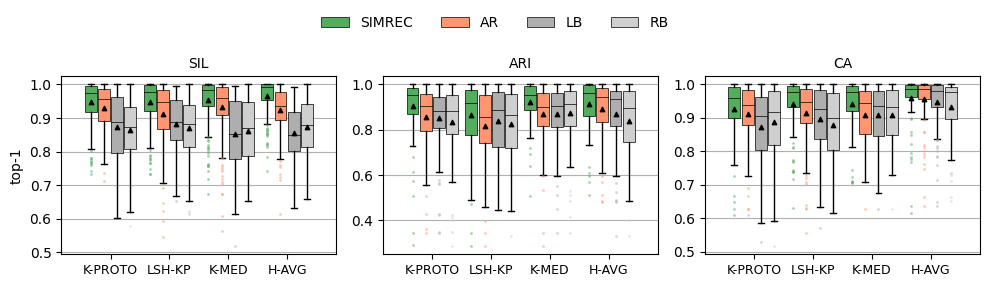

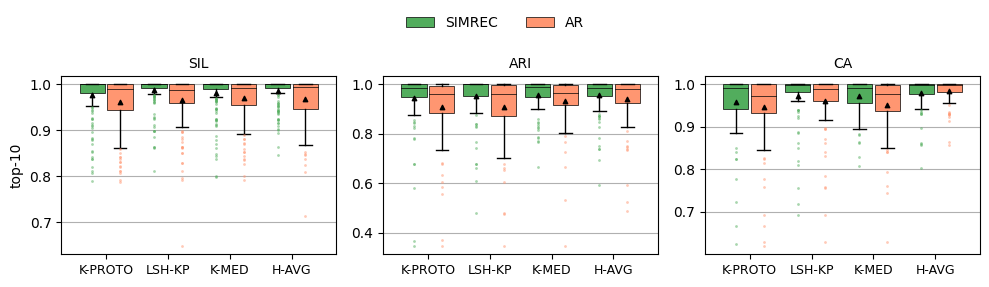

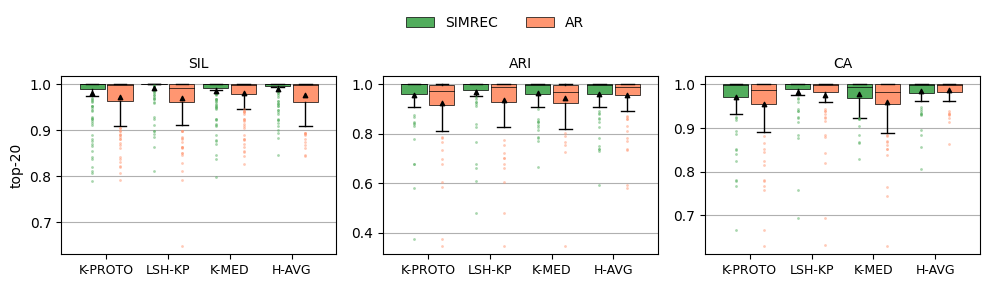

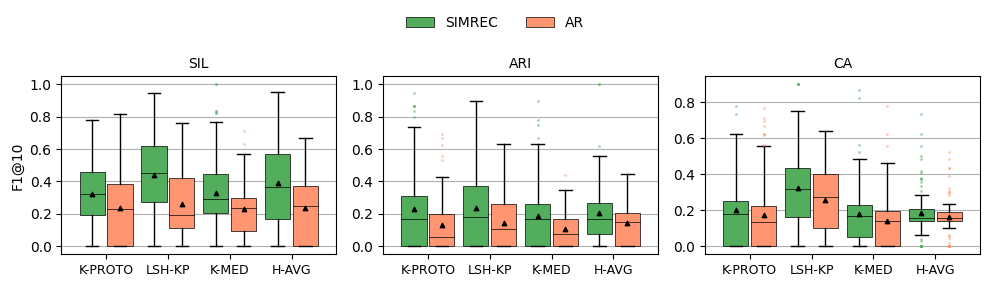

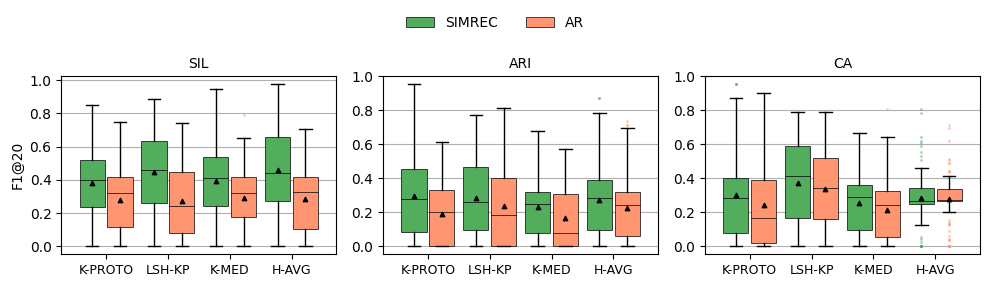

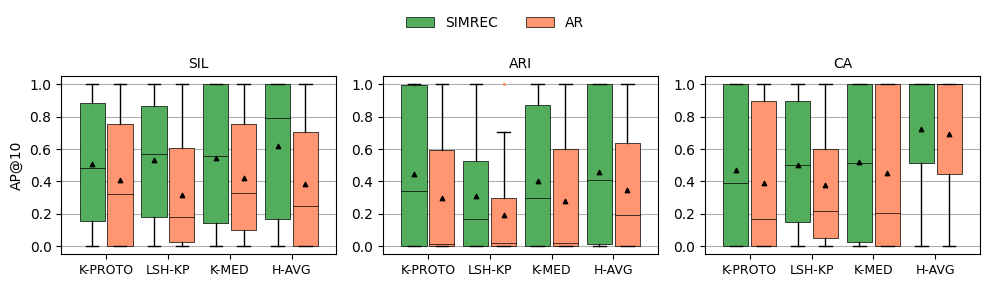

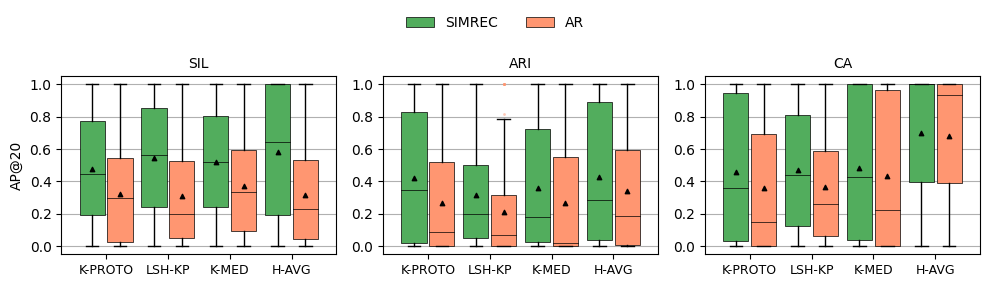

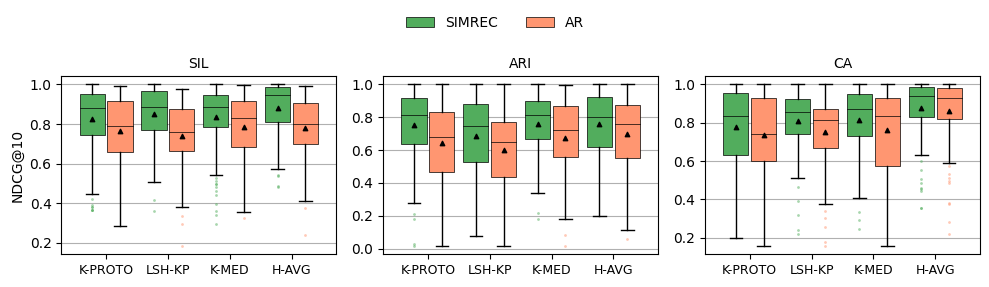

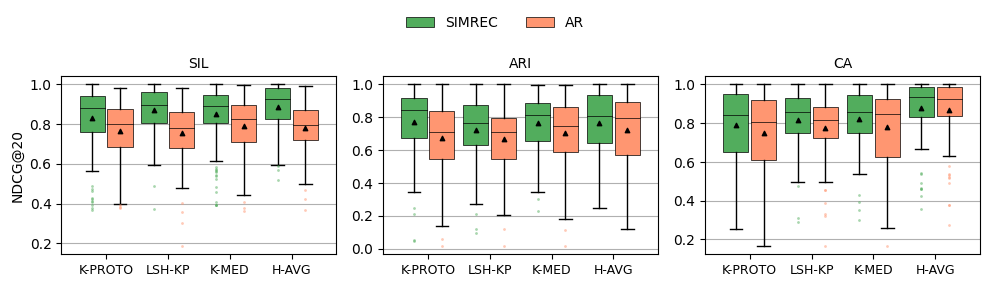

In [12]:
savedir= None # "imgs/"
for k in [1, 10, 20]:
    show_top_k(results, k=k, savedir=savedir)
for k in [10, 20]:
    show_f1(results, k=k, savedir=savedir)
for k in [10, 20]:
    show_ap(results, k=k, savedir=savedir)
for k in [10, 20]:
    show_ndcg(results, k=k, savedir=savedir)

In [6]:
from scipy.stats import wilcoxon, ttest_rel

model_name = "AMF-FS-KNN"
baselines = ["LB", "RB", "AR"]
k = 1
y_1 = {}
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_1:
        y_1[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        for name in baselines:
            res = results[algorithm][cvi]["scores"]
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_1[algorithm[0]][f"{cvi}-{name}"] = f"{p:.1g}"
print(f"top-{1} ################################")
print(pd.DataFrame.from_dict(y_1, orient='index'))
print()

baselines = ["AR"]

y_top = {}
k = 10
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_top:
        y_top[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["scores"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_top[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"top-{k} ################################")
print(pd.DataFrame.from_dict(y_top, orient='index'))
print()

y_top = {}
k = 20
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_top:
        y_top[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["scores"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_top[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"top-{k} ################################")
print(pd.DataFrame.from_dict(y_top, orient='index'))
print()

y_f1 = {}
k = 10
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_f1:
        y_f1[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["f1"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_f1[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"F1@{k} ################################")
print(pd.DataFrame.from_dict(y_f1, orient='index'))
print()

y_f1 = {}
k = 20
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_f1:
        y_f1[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["f1"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_f1[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"F1@{k} ################################")
print(pd.DataFrame.from_dict(y_f1, orient='index'))
print()

y_ap = {}
k = 10
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_ap:
        y_ap[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["ap"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_ap[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"AP@{k} ################################")
print(pd.DataFrame.from_dict(y_ap, orient='index'))
print()

y_ndcg = {}
k = 10
for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
    if algorithm[0] not in y_ndcg:
        y_ndcg[algorithm[0]] = {}
    for cvi in ["sil", "ari", "acc"]:
        res = results[algorithm][cvi]["ndcg"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_ndcg[algorithm[0]][f"{cvi}-{name}"] = f"{p:.2g}"
print(f"NDCG@{k} ################################")
print(pd.DataFrame.from_dict(y_ndcg, orient='index'))

top-1 ################################
  sil-LB sil-RB sil-AR  ari-LB ari-RB  ari-AR acc-LB  acc-RB acc-AR
k  7e-18  1e-21  3e-06   1e-05  2e-05  0.0006  1e-05  0.0008   0.03
l  5e-18  5e-18  6e-08    0.05   0.02  0.0004  7e-05   1e-07  0.004
f  1e-24  2e-20  2e-07   8e-06  0.001   5e-05  2e-05   6e-05  4e-05
h  2e-28  8e-24  4e-14  0.0002  9e-06   0.007  0.008   3e-05   0.06

top-10 ################################
    sil-AR   ari-AR   acc-AR
k  4.2e-09  0.00016     0.01
l  2.9e-12  9.1e-06   0.0012
f  2.8e-06   0.0014  0.00013
h  6.8e-07    0.045     0.73

top-20 ################################
    sil-AR   ari-AR   acc-AR
k  4.5e-05  6.1e-05  0.00017
l  3.5e-14  7.4e-05    0.046
f  0.00018   0.0023  0.00078
h  8.2e-07     0.29     0.69

F1@10 ################################
    sil-AR   ari-AR   acc-AR
k  1.3e-07  0.00028    0.052
l  4.4e-18  2.1e-06  8.9e-05
f  6.7e-08  3.4e-05    0.054
h  1.4e-08  4.3e-05     0.04

F1@20 ################################
    sil-AR   ari-AR   ac

[57, 57, 57]
kprototypes sil 0.15326587378730386
[32, 31, 32]
kprototypes ari 0.13122220413845137
[32, 31, 32]
kprototypes acc 0.16761861247630164


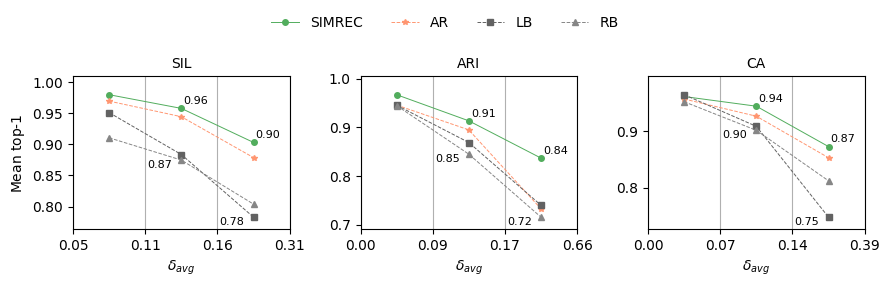

[56, 55, 55]
lshkprototypes sil 0.11549401015254906
[31, 31, 31]
lshkprototypes ari 0.04768087835366988
[31, 31, 31]
lshkprototypes acc 0.11517745123949523


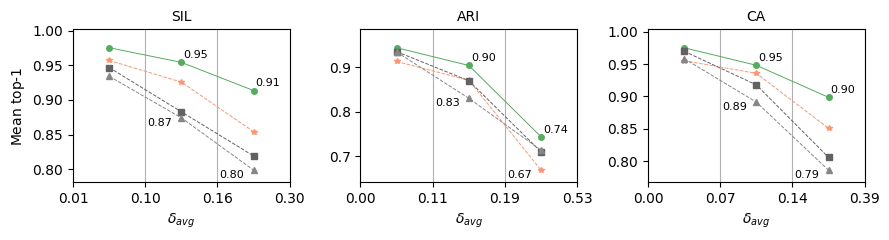

[58, 57, 58]
fasterpam sil 0.22003175653331988
[32, 32, 32]
fasterpam ari 0.1639263007531259
[32, 32, 32]
fasterpam acc 0.10620387146528262


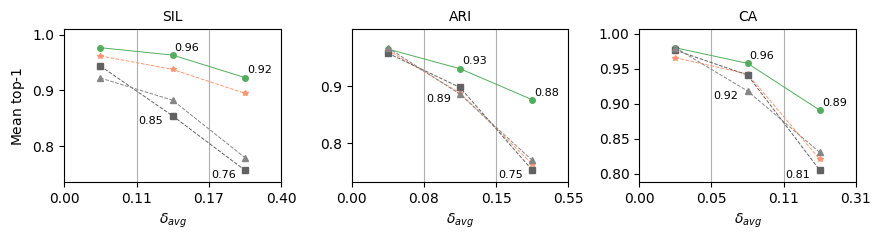

[58, 57, 58]
haverage sil 0.19368404481356122
[32, 32, 32]
haverage ari 0.14295191772374385
[32, 32, 32]
haverage acc 0.036309889695800596


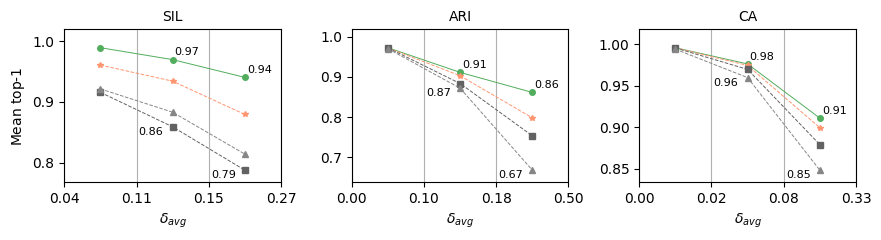

In [7]:
def show_results_delta(results, cvi="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "AR": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "AR": "--*",
        "LB": "--s",
        "RB": "--^"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"

    for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
        plt.figure(figsize=(3*3, 2.5))
        j = 1
        for cvi in ["sil", "ari", "acc"]:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][cvi]["Y"]
            lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
            lower_bound_cvi = lower_bound(cvi)
            Yn =  np.array([(y-lower_bound_cvi)/max(y-lower_bound_cvi) for y in Y])
            Yn[Yn <= 0] = -1
            Yn = Yn[lb_scores>-1]

            res = results[algorithm][cvi]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            # baselines = []
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    ln = ((scores-lower_bound(cvi))/(best_scores-lower_bound(cvi)))[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    ln = ((scores-lower_bound(cvi))/(best_scores-lower_bound(cvi)))[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)
            
            print(algorithm, cvi, (y["AMF-FS-KNN"][-1] - y["LB"][-1])/y["LB"][-1])

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=labels[model_name] if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title("CA" if cvi=="acc" else cvi.upper(), fontsize=10)

            j += 1

        # if cvi=="sil":
        #     plt.figlegend(loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines), fontsize=10)
        if algorithm == "kprototypes": plt.figlegend(fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(colors))

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algorithm}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results, savedir="imgs") #, savedir="imgs"

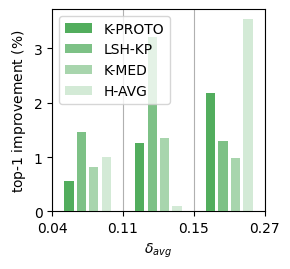

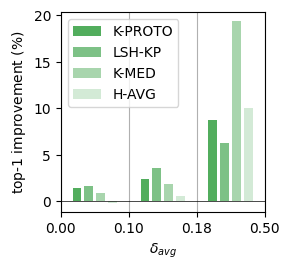

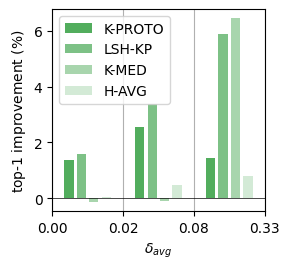

In [57]:
def show_impact_fs_delta(results, cvi="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AMF-KNN"]
    color = "#52AD5D"
    alpha = {
        "kprototypes": 1,
        "lshkprototypes": 0.75,
        "fasterpam": 0.5,
        "haverage": 0.25,
        # # "AMF-AE-KNN": "#FF9671",
        # "fasterpam": "#FF9671",
        # # "AR": "#868686",
        # "haverage": "#AEAEAE",
    }

    linestyle = {
        "kprototypes": "-o",
        "fasterpam": "--*",
        "haverage": "--s",
    }
    k = 1
    for cvi in ["sil", "ari", "acc"]:
        y = {}
        yerr = {}
        plt.figure(figsize=(3, 2.8))
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            y[algorithm] = []
            yerr[algorithm] = []
            Y = train_res[algorithm][cvi]["Y"]
            lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
            Yn =  np.array([(y-lower_bound(cvi))/max(y-lower_bound(cvi)) for y in Y])
            Yn[Yn <= 0] = -1
            Yn = Yn[lb_scores>-1]

            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            res = results[algorithm][cvi]["scores"]
            best_scores = res["Oracle"][1]
            l1 = res[model_names[0]][k]
            l1 = (l1-lower_bound(cvi))/(best_scores-lower_bound(cvi))
            l2 = res[model_names[1]][k]
            l2 = (l2-lower_bound(cvi))/(best_scores-lower_bound(cvi))
            v = (l1 - l2)/l2
            for indices in list_indices:
                y[algorithm].append(np.mean(v[indices])*100)
                yerr[algorithm].append(np.std(v[indices])*100)

        z = np.arange(len(x))
        n_bar = len(y)
        w = 0.7/n_bar
        boxes = []
        i = 0
        for algorithm, values in y.items():
            # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
            #                 linewidth=0)
            # medianprops = dict(color='black', linewidth=0.5)
            # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            plt.bar(z[:-1]+(i*w-(n_bar-1)*w/2)+0.5, values, width=w*0.75, label=names[algorithm], color=color, alpha=alpha[algorithm], zorder=5)
            i+=1

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"top-${k}$ improvement (%)")
        plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
        plt.grid(axis="x")
        plt.xlabel("$\delta_{avg}$")
        plt.axhline(linewidth=0.5, color="black", zorder=10)

        plt.legend(fontsize=10)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"impact_fs_delta_{cvi}.pdf"), bbox_inches='tight')
        plt.show()

show_impact_fs_delta(results, savedir="imgs") #

In [8]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics_num = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "covariance",
    ]
]
attributes_statistics_cat = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "card_cat_att", "entropy_cat_att",
    ]
]
proposed_attributes_statistics_num = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_squared_num_att", "std_squared_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
    ]
]
proposed_attributes_statistics_cat = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]
proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_squared_num_att", "std_squared_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

features = {
    "d": dataset_statistics,
    "n_at": attributes_statistics_num,
    "c_at": attributes_statistics_cat,
    "p_n_at": proposed_attributes_statistics_num,
    "p_c_at": proposed_attributes_statistics_cat,
}

In [11]:
algorithm = "haverage"
for cvi in ["sil", "ari", "acc"]:
    obj = {}
    for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
        obj[names[algorithm]] = {}
        selected_features = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["selected_features_names"]
        for k, list_features in features.items():
            l = [f for f in list_features if f in selected_features]
            obj[names[algorithm]][k] = f"{len(l)} ({round(len(l)/len(selected_features)*100)}%)"
            # obj[algorithm][k] = f"{len(l)/len(selected_features)*100:.1f}"
            # obj[k]["feats"] = [f for f in list_features if f in selected_features]
        obj[names[algorithm]]['total'] = len(selected_features)
    print(pd.DataFrame.from_dict(obj, orient='index').to_latex())

\begin{tabular}{llllllr}
\toprule
{} &        d &     n\_at &     c\_at &   p\_n\_at &   p\_c\_at &  total \\
\midrule
K-PROTO &  4 (13\%) &  7 (23\%) &  7 (23\%) &  7 (23\%) &  5 (17\%) &     30 \\
LSH-KP  &  3 (12\%) &  4 (17\%) &  5 (21\%) &  5 (21\%) &  7 (29\%) &     24 \\
K-MED   &  4 (15\%) &  5 (19\%) &  6 (23\%) &  7 (27\%) &  4 (15\%) &     26 \\
H-AVG   &  5 (22\%) &  3 (13\%) &  4 (17\%) &  6 (26\%) &  5 (22\%) &     23 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllr}
\toprule
{} &        d &     n\_at &     c\_at &   p\_n\_at &   p\_c\_at &  total \\
\midrule
K-PROTO &   2 (6\%) &  9 (27\%) &  6 (18\%) &  9 (27\%) &  7 (21\%) &     33 \\
LSH-KP  &   3 (9\%) &  8 (24\%) &  6 (18\%) &  9 (27\%) &  7 (21\%) &     33 \\
K-MED   &  2 (13\%) &  2 (13\%) &  3 (20\%) &  2 (13\%) &  6 (40\%) &     15 \\
H-AVG   &   1 (3\%) &  6 (20\%) &  8 (27\%) &  9 (30\%) &  6 (20\%) &     30 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllr}
\toprule
{} &        d &     n\_at &     c\

/tmp/ipykernel_1383120/2047979768.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(obj, orient='index').to_latex())
/tmp/ipykernel_1383120/2047979768.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(obj, orient='index').to_latex())
/tmp/ipykernel_1383120/2047979768.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting a

In [60]:
def rename(name):
    ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
    if name == "n_instances":
        return "NbSamples"
    if name == "n_features":
        return "NbAttributes"
    if name == "dim":
        return "Dim"
    if name == "num_on_cat":
        return "NumOnCat"
    if name == "n_num_att":
        return "NbNumAtt"
    if name == "n_cat_att":
        return "NbCatAtt"
    l = name.split("_")
    for i in range(1, len(l)):
        if l[i] == "squared":
            l[i] = "sq"
        if l[i] == "internal":
            l[i] = "int"
        if l[i] == "product":
            l[i] = "prod"
        if l[i] != "" and i>0:
            l[i] = l[i][0].upper() + l[i][1:]
    return l[0]+ "-" + "".join(l[1:])

/tmp/ipykernel_1355365/359561050.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greens', 256)


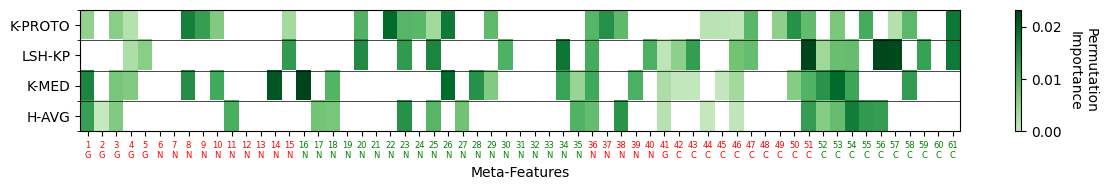

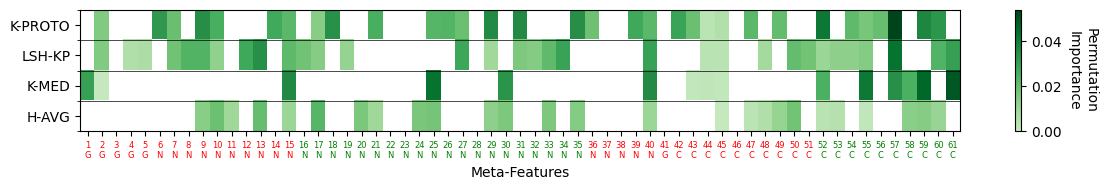

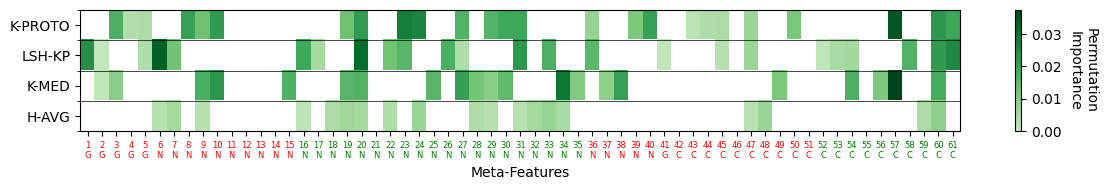

In [61]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = cm.get_cmap('Greens', 256)
newcolors = cmap(np.linspace(0.25, 1, 256))
pink = np.array([1, 1, 1, 1])
newcolors[0] = pink
newcmp = ListedColormap(newcolors)

scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))

for cvi in ["sil", "ari", "acc"]:
    y = []
    for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
        params = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["params"]
        selected_feats = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["selected_features"]
        X = train_res[algorithm][cvi]["X"][:, selected_feats]
        Y = train_res[algorithm][cvi]["Y"]
        Yn = train_res[algorithm][cvi]["Yn"]
        feature_importance = None
        for train, test in KFold(n_splits=10).split(X):
            knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
            result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
            if feature_importance is None:
                feature_importance = result.importances.mean(axis=1)
            else:
                feature_importance = feature_importance + result.importances.mean(axis=1)
        l = np.zeros(len(selected_feats))
        l[selected_feats] = feature_importance/10
        y.append(l)
    y = np.array(y)

    fig, ax = plt.subplots(figsize=(12, 2))
    im = ax.imshow(y, cmap=newcmp, vmin=0, aspect="auto")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Permutation\nImportance", rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(meta_features_df.shape[1]), labels=[f"{i+1}\n{'N' if f in proposed_attributes_statistics_num else 'C'}" if f in proposed_attributes_statistics else f"{i+1}\n{'G' if f in dataset_statistics else ('N' if f in attributes_statistics_num else 'C')}" for i, f in enumerate(meta_features_df.columns)], fontsize=6)
    ax.set_yticks(np.arange(4), labels=[names[algorithm] for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]])
    ax.set_yticks(np.arange(4+1)-.5, minor=True)
    # ax.spines[:].set_visible(False)
    ax.grid(which="minor", axis="y", color="black", linestyle='-', linewidth=0.5)

    # ax.tick_params(axis='x', colors=["green" if f in proposed_attributes_statistics else "red" for f in mixed_meta_df.columns])
    colors = ["green" if f in proposed_attributes_statistics else "red" for f in meta_features_df.columns]
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    # for i in range(3):
    #     for j in range(mixed_meta_df.shape[1]):
    #         text = ax.text(j, i, y[i, j],
    #                     ha="center", va="center", color="w")

    ax.set_xlabel("Meta-Features")
    fig.tight_layout()
    plt.savefig(f"imgs/importance_{cvi}.pdf", bbox_inches='tight')
    plt.show()

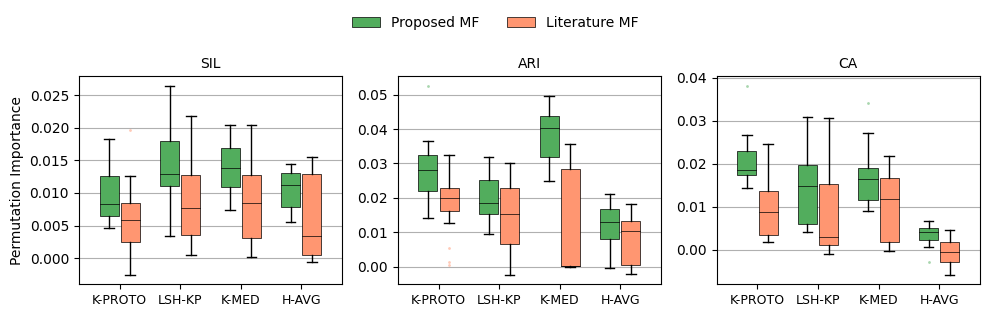

In [64]:
from sklearn.metrics import make_scorer
scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))

def show_feat_imp(train_res, savedir=None):
    labels = ["Proposed MF", "Literature MF"]
    colors = dict(zip(labels, ["#52AD5D", "#FF9671"]))
    fig = plt.figure(figsize=(10, 2.8))
    k = 1
    for j, cvi in enumerate(["sil", "ari", "acc"]):
        y = {"Proposed MF": [], "Literature MF": []}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]:
            params = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["params"]
            selected_feats = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["selected_features"]
            selected_feat_names = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["selected_features_names"]
            X = train_res[algorithm][cvi]["X"][:, selected_feats]
            Y = train_res[algorithm][cvi]["Y"]
            Yn = train_res[algorithm][cvi]["Yn"]
            feature_importance = None
            for train, test in KFold(n_splits=10).split(X):
                knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
                result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
                if feature_importance is None:
                    feature_importance = result.importances.mean(axis=1)
                else:
                    feature_importance = feature_importance + result.importances.mean(axis=1)
            feature_importance /= 10
            y["Proposed MF"].append(feature_importance[[f in proposed_attributes_statistics for f in selected_feat_names]])
            y["Literature MF"].append(feature_importance[[f not in proposed_attributes_statistics for f in selected_feat_names]])

        n_bar = len(y)
        w = 0.7/n_bar
        x = np.arange(len(train_res))
        boxes = []
        i = 0
        for label, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[label], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[label], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel("Permutation Importance")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "lshkprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(cvi.upper() if cvi != "acc" else "CA", fontsize=10)
    plt.figlegend([box["boxes"][0] for box in boxes], labels, fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=2)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"feature_importance_top_{k}.pdf"), bbox_inches='tight')
    plt.show()

show_feat_imp(train_res, savedir="imgs/") #

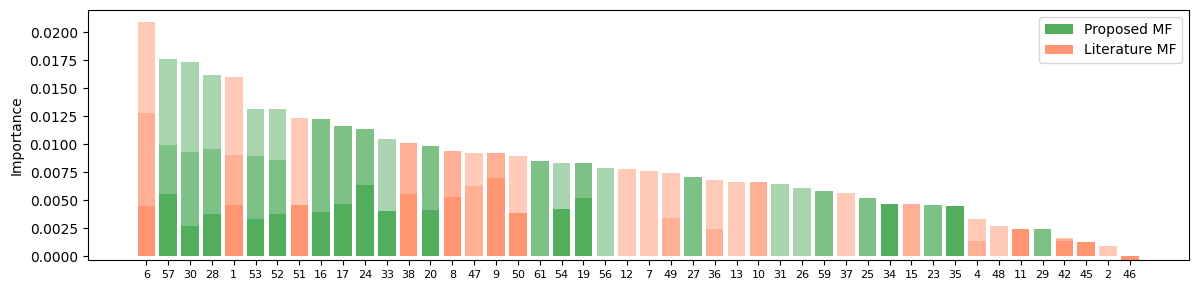

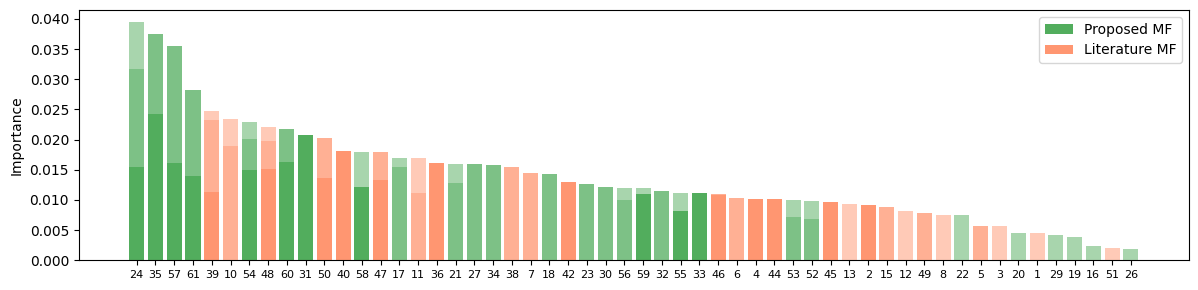

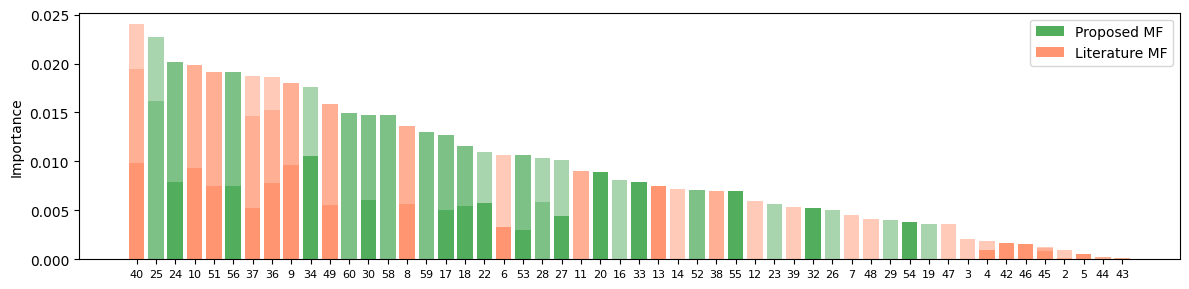

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))
patterns = ["-", "|", "\\"]
for cvi in ["sil", "ari", "acc"]:
    y = {}
    for algorithm in ["kprototypes", "fasterpam", "haverage"]:
        params = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["params"]
        selected_feats = train_res[algorithm][cvi]["train_results"]["AMF-FS-KNN"]["selected_features"]
        X = train_res[algorithm][cvi]["X"][:, selected_feats]
        Y = train_res[algorithm][cvi]["Y"]
        Yn = train_res[algorithm][cvi]["Yn"]
        feature_importance = None
        for train, test in KFold(n_splits=10).split(X):
            knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
            result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
            if feature_importance is None:
                feature_importance = result.importances.mean(axis=1)
            else:
                feature_importance = feature_importance + result.importances.mean(axis=1)
        y[algorithm] = np.zeros(len(selected_feats))
        y[algorithm][selected_feats] = feature_importance/10
    sum_y = np.array(list(y.values())).sum(axis=0)
    indices = np.array([i for i in np.argsort(-sum_y) if sum_y[i]>0])
    feature_names = [rename(feat) for feat in mixed_meta_df.columns.to_numpy()[indices]]
    plt.figure(figsize=(12, 3))
    bottom = 0
    i = 0
    for algorithm, values in y.items():
        y_ = np.array([v if mixed_meta_df.columns[i] in proposed_attributes_statistics else 0 for i, v in enumerate(values)])
        plt.bar(feature_names, y_[indices], bottom=bottom, label="Proposed MF" if i==0 else "", color="#52AD5D", alpha=1-i*0.25)
        y_ = np.array([v if mixed_meta_df.columns[i] not in proposed_attributes_statistics else 0 for i, v in enumerate(values)])
        plt.bar(feature_names, y_[indices], bottom=bottom, label="Literature MF" if i==0 else "", color="#FF9671", alpha=1-i*0.25)
        bottom += values[indices]
        i += 1
    plt.ylabel("Importance")
    plt.xticks(feature_names, indices+1, fontsize=8)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"imgs/importance_{cvi}.pdf")
    plt.show()

In [14]:
from simrec import recommend
import time
from sklearn.preprocessing import minmax_scale
def load_dataset(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data["Xnum"], data["Xcat"]

times = {}
dataset_dir = "/homedir/adiop/workspace/simrec-for-mdc/datasets"
clustering_result_dir = "/homedir/adiop/workspace/simrec-for-mdc/meta_dataset_creation/data/benchmark_results/lshkprototypes/clustering_results"
models_dir = "/homedir/adiop/workspace/simrec-for-mdc/meta_model_training/data/saved_models"
algorithm = "lshkprototypes"
cvi = "sil"
for i, filename in enumerate(os.listdir(clustering_result_dir)):
    print(i)
    Xnum, Xcat = load_dataset(os.path.join(dataset_dir, filename))
    Xnum = minmax_scale(Xnum)
    t0 = time.time()
    recommendation = recommend(Xnum, Xcat, models_dir, algorithm=algorithm, cvi=cvi)
    t1 = time.time()

    clustering_time = 0
    with open(os.path.join(clustering_result_dir, filename), "rb") as fp:
        clustering_results = pickle.load(fp)
    for result in clustering_results[recommendation[0][0]]:
        clustering_time += result["time"]

    data_id = filename.split('.')[0]
    times[data_id] = {}
    times[data_id]["recommendation_time"] = t1 - t0
    times[data_id]["clustering_time"] = clustering_time

0
1
2
3
4
5
6
7
8
9
10
11


12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


In [16]:
import json

with open("recommendation_vs_clistering_time.json", "w") as fp:
    json.dump(times, fp, indent=4)

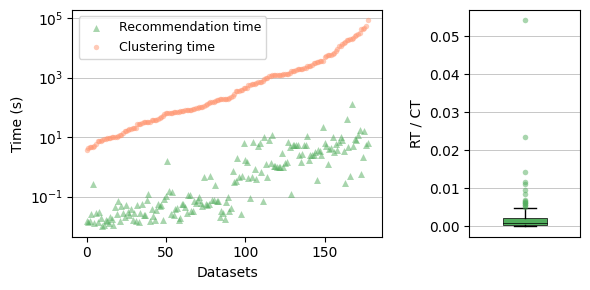

In [31]:
x = [t["recommendation_time"] for t in times.values()]
y = [t["clustering_time"] for t in times.values()]
indices = np.argsort(y)
x = np.array(x)[indices]
y = np.array(y)[indices]

plt.rcParams['text.usetex'] = False
plt.figure(figsize=(6, 3))
plt.subplot(1, 3, (1, 2))
plt.scatter(np.arange(len(x)), x, marker="^", s=25, label="Recommendation time", c="#52AD5D", linewidths=0, alpha=0.5, zorder=2)
plt.scatter(np.arange(len(y)), y, s=15, label="Clustering time", c="#FF9671", linewidths=0, alpha=0.5, zorder=2)
plt.yscale("log")
# plt.axhline(y=np.quantile(x/y*120, 0.25), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.5), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.75), color="gray", linewidth=0.5)
plt.grid(axis="y", linewidth=0.5)
plt.ylabel("Time (s)")
plt.xlabel("Datasets")
plt.legend(fontsize=9)
plt.subplot(1, 3, 3)
boxprops = dict(linewidth=0.5, facecolor="#52AD5D", alpha=1) # "#52AD5D", "#FF9671"
flierprops = dict(marker='o', markerfacecolor="#52AD5D", markeredgecolor='none', markersize=4, alpha=0.5,
                linewidth=0)
medianprops = dict(color='black', linewidth=0.5)
meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
b = plt.boxplot([x/y], widths=0.4, patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
plt.xticks([])
# plt.ylabel(r"$\frac{\text{Recommendation Time}}{\text{Clustering Time}}$", fontsize=12)
plt.ylabel("RT / CT")
# plt.yscale("log")
plt.grid(axis="y", linewidth=0.5)
plt.tight_layout(w_pad=2)
# plt.savefig(f"imgs/inference_time_kprototypes.pdf")
plt.show()